### K-Means Clustering on Bounding Boxes of *hardhat,mask,vest,boots* dataset

#### 1: Downloading annotations file containing the dimensions of bounding boxes

In [1]:
!wget https://github.com/ashxjain/eva/raw/master/P5_S12/images_vgg_image_annotations.jso

--2020-10-17 06:05:27--  https://github.com/ashxjain/eva/raw/master/P5_S12/images_vgg_image_annotations.json
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashxjain/eva/master/P5_S12/images_vgg_image_annotations.json [following]
--2020-10-17 06:05:27--  https://raw.githubusercontent.com/ashxjain/eva/master/P5_S12/images_vgg_image_annotations.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126468 (124K) [text/plain]
Saving to: ‘images_vgg_image_annotations.json’

images_vgg_image_an 100%[===================>] 123.50K  --.-KB/s    in 0.04s   

2020-10-17 06:05:27 (3.13 MB/s) - ‘images_vgg_image_a

#### 2: Load the annnotations json file

In [43]:
import json

with open('images_vgg_image_annotations.json') as f:
  data = json.load(f)
  print("loaded json data successfully")

loaded json data successfully


#### 3: Get dimensions of each image

In [44]:
from urllib import request as ulreq
from PIL import ImageFile
 
def get_dim_from_image_url(uri):
    # get image dimensions (None if not known)
    file = ulreq.urlopen(uri)
    def get_dim():
      p = ImageFile.Parser()
      while True:
          data = file.read(1024)
          if not data:
              break
          p.feed(data)
          if p.image:
              return p.image.size
      return None
    size = get_dim()
    file.close()
    return size

#### 4: Compute the centre location, width and height of each bounding box, and normalise it by image dimensions

In [ ]:
from collections import namedtuple

img_size = namedtuple('img_metadata', 'filename img_w img_h')
bbox = namedtuple('bbox', 'norm_cx norm_cy norm_w norm_h')

img_sizes = []
bboxes = []
urlprefix = "https://github.com/ashxjain/eva/raw/master/P5_S12/images/"

for img_obj in data:
  obj = data[img_obj]
  img_w, img_h = get_dim_from_image_url(urlprefix+obj["filename"])
  img_sizes.append(img_size(obj['filename'], img_w, img_h))
  for region in obj["regions"]:
    norm_cx = region["shape_attributes"]["x"] /img_w
    norm_cy = region["shape_attributes"]["y"] / img_h
    norm_w = region["shape_attributes"]["width"] / img_w
    norm_h = region["shape_attributes"]["height"] / img_h
    bboxes.append(bbox(norm_cx, norm_cy, norm_w, norm_h))

#### 5: Plot the h & w for each bounding box

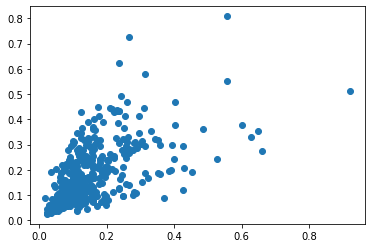

In [37]:
from matplotlib import pyplot as plt
import numpy as np

wh = [(b.norm_w, b.norm_h) for b in bboxes]
np_wh = np.array(wh)
plt.scatter(np_wh[:,0], np_wh[:,1])

#### 6: Find optimal number of clusters using Elbow Method
* We graph the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then we select the number of clusters where the change in WCSS begins to level off.
* WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.
* We train multiple models using a different number of clusters and storing the value of the intertia_ property (WCSS) every time.

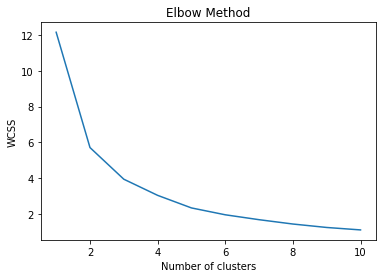

In [38]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(np_wh)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### 7: Categorize the data using optimum number of clusters (5)

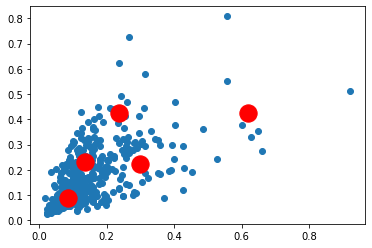

In [40]:
# k-means++ ensures that you don’t fall into the random initialization tra
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(np_wh)
plt.scatter(np_wh[:,0], np_wh[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

#### 8: Final cluster values [bounding boxes]

In [42]:
print(kmeans.cluster_centers_)

[[0.08483493 0.08602006]
 [0.23510401 0.42370416]
 [0.13661584 0.23031227]
 [0.29969706 0.22231716]
 [0.62021337 0.42348333]]
